use the total distance to compute average performance of an attack on  a model type. evaluate each model on the test dataset. then perturn 25%, 50%, 75% and 100% of the test set then evalaute the model accuracy on these AE

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [2]:
print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.15.0


In [3]:
# pathh = 'MNISTClassifier'

# for parent, dirs, files in os.walk(pathh, topdown=False):
#   for file in files:
#     file_path = os.path.join(parent, file)
#     os.remove(file_path)
#   for dir in dirs:
#     dir_path = os.path.join(parent, dir)
#     os.rmdir(dir_path)

# os.rmdir('./MNISTClassifier')

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
# x_train, x_test = images, test_images
# y_train, y_test = labels, test_labels

In [5]:
train_images = np.asarray([cv2.cvtColor(im, cv2.COLOR_GRAY2RGB) for im in train_images])
test_images = np.asarray([cv2.cvtColor(im, cv2.COLOR_GRAY2RGB) for im in test_images])

In [6]:
print('x_train.shape', train_images.shape)
print('y_train.shape', train_images.shape)


x_train.shape (60000, 28, 28, 3)
y_train.shape (60000, 28, 28, 3)


In [7]:
train_images = np.asarray([cv2.resize(im, (64, 64), interpolation=cv2.INTER_NEAREST) for im in train_images])
test_images = np.asarray([cv2.resize(im, (64, 64), interpolation=cv2.INTER_NEAREST) for im in test_images])

In [8]:
x_test, y_test = test_images, test_labels

In [9]:
# feed all data into train test split

In [10]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, random_state=104, test_size=0.166655, shuffle=True)

In [11]:
print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)
print('x_val.shape', x_val.shape)
print('y_val.shape', y_val.shape)
print('x_test.shape', x_test.shape)
print('y_test.shape', y_test.shape)

x_train.shape (50000, 64, 64, 3)
y_train.shape (50000,)
x_val.shape (10000, 64, 64, 3)
y_val.shape (10000,)
x_test.shape (10000, 64, 64, 3)
y_test.shape (10000,)


(64, 64, 3)


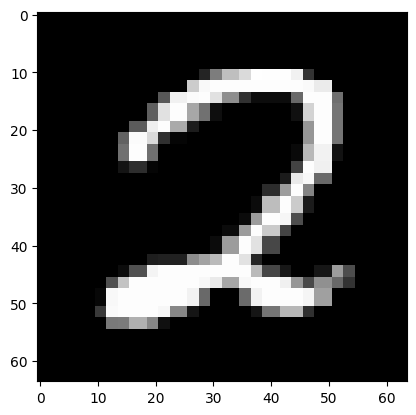

In [12]:
x_test_43 = x_test[35]

print(x_test_43.shape)
digit = x_test_43
fig = plt.figure
plt.imshow(digit)
# print(x_test_43)

#twos are located at [(1, 2), (35, 2), (38, 2), (43, 2), (47, 2), (72, 2), (77, 2), (82, 2), (106, 2), (119, 2)]

In [13]:
few_twos = []
count = 0
for index, label in enumerate(y_test):
  if count > 9:
    break
  if label == 2:
    few_twos.append((index, label))
    count += 1

print(few_twos)
#select labels that are digit 2

[(1, 2), (35, 2), (38, 2), (43, 2), (47, 2), (72, 2), (77, 2), (82, 2), (106, 2), (119, 2)]


# Networks

## Custom

In [14]:
class MNISTClassifier(tf.keras.Model):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # Define the layers
        #for feature extration
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1))
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                           self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]
    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob

## Backbone Networks

In [15]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [16]:
class VGG16model(tf.keras.Model):
    def __init__(self, base_model):
        super(VGG16model, self).__init__()
        #instantiate base model
        self.base_model = base_model
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.base_model, self.flatten, self.dense1, self.dense2]

    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob
    

In [45]:
input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
base_model = VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
base_model.trainable = False



In [46]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Model fit and saving

In [18]:
class SavefinalTrainingLogitsProp(keras.callbacks.Callback):
    def on_train_end(self, logs):
        self.out = model.predict(x_train)
        self.prob = tf.nn.softmax(self.out)
        print(self.out.shape, self.prob.shape)

In [19]:
def plot_loss_acc(train_metric_values, val_metric_values, type=None, plt_title=None):
    epochs = range(1, len(train_metric_values) +1)
    plt.plot(epochs, train_metric_values, 'bo', label=f'Training {type}')
    plt.plot(epochs, val_metric_values, 'b', label=f'validation {type}')
    plt.title(plt_title)
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    plt.legend()
    plt.show()
    
    

In [20]:
model_custom = MNISTClassifier()
model_custom.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

custom_history = model_custom.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
# model_custom.save('MNISTClassifier')

Epoch 1/10


2024-03-04 14:29:14.891159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 18s 10ms/step - loss: 0.3815 - accuracy: 0.8869 - val_loss: 0.1605 - val_accuracy: 0.9543
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2196 - accuracy: 0.9451 - val_loss: 0.1506 - val_accuracy: 0.9649
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2672 - accuracy: 0.9507 - val_loss: 0.2118 - val_accuracy: 0.9671
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.5132 - accuracy: 0.9441 - val_loss: 0.5054 - val_accuracy: 0.9599
Epoch 5/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0221 - accuracy: 0.9442 - val_loss: 0.8282 - val_accuracy: 0.9607
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2008 - accuracy: 0.9398 - val_loss: 1.9457 - val_accuracy: 0.9628
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 5.7886 - accuracy: 0.9314 - val_loss: 5.8466 - val_accuracy:

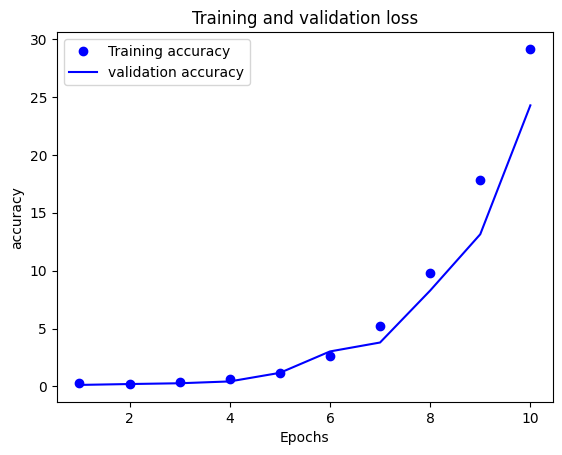

In [23]:
loss_values = custom_history.history["loss"]
val_loss_values = custom_history.history["val_loss"]
plot_loss_acc(loss_values, val_loss_values, type='accuracy',  plt_title="Training and validation loss")

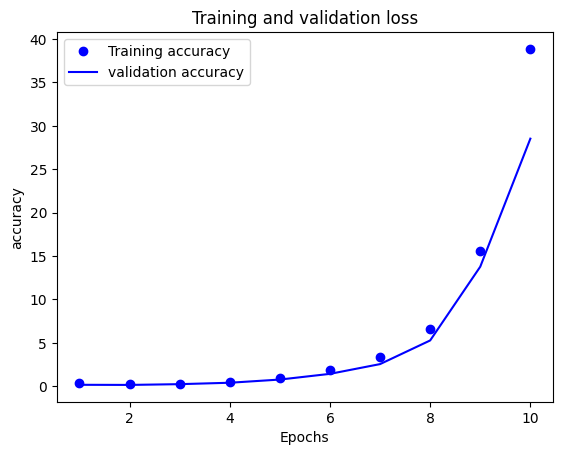

In [17]:
loss_values = custom_history.history["loss"]
val_loss_values = custom_history.history["val_loss"]
plot_loss_acc(loss_values, val_loss_values, type='accuracy',  plt_title="Training and validation loss")

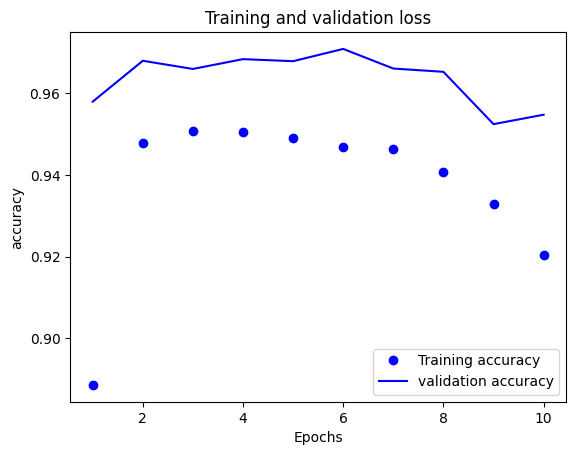

In [18]:
loss_values = custom_history.history["accuracy"]
val_loss_values = custom_history.history["val_accuracy"]
plot_loss_acc(loss_values, val_loss_values, type='accuracy',  plt_title="Training and validation loss")

In [ ]:
loss_values = custom_history.history["loss"]
val_loss_values = custom_history.history["val_loss"]
plot_loss_acc(loss_values, val_loss_values, type='accuracy',  plt_title="Training and validation loss")

In [47]:
model_vgg16 = VGG16model(base_model)
model_vgg16.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

vgg16_history = model_vgg16.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
# model_vgg16.save('VGG16Classifier')

Epoch 1/5
1563/1563 [==============================] - 36s 23ms/step - loss: 0.4795 - accuracy: 0.8941 - val_loss: 0.1815 - val_accuracy: 0.9575
Epoch 2/5
1563/1563 [==============================] - 35s 23ms/step - loss: 0.1388 - accuracy: 0.9652 - val_loss: 0.1124 - val_accuracy: 0.9716
Epoch 3/5
1563/1563 [==============================] - 35s 22ms/step - loss: 0.0957 - accuracy: 0.9746 - val_loss: 0.0892 - val_accuracy: 0.9757
Epoch 4/5
1563/1563 [==============================] - 35s 23ms/step - loss: 0.0771 - accuracy: 0.9788 - val_loss: 0.0822 - val_accuracy: 0.9758
Epoch 5/5
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0660 - accuracy: 0.9820 - val_loss: 0.0695 - val_accuracy: 0.9789


# Load model and make predictions

## prepare images and labels

In [21]:
twos_tupple = [(1, 2), (35, 2), (38, 2), (43, 2), (47, 2), (72, 2), (77, 2), (82, 2), (106, 2), (119, 2)]
reshaped_sample_twos = []
class_arr = []

for tup in twos_tupple:
    a_two = x_test[tup[0]]
    print('a_two.shape', a_two.shape)
    a_two = np.reshape(a_two, (-1, 64, 64, 3))
    print('a_two.shape', a_two.shape)
    a_two_label = y_test[tup[0]]
    a_two_label = tf.convert_to_tensor(a_two_label)
    class_arr.append(a_two_label)
    # print(a_two_label)
    reshaped_sample_twos.append(a_two)
reshaped_sample_twos = np.array(reshaped_sample_twos)

a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)


In [22]:
print(y_test[35])

2


In [23]:
# model_mnist = tf.keras.models.load_model('MNISTClassifier')

predictions = []
for sample in reshaped_sample_twos:
    sample_prediction = model_custom.predict(sample)
    predictions.append(sample_prediction)
#check a prediction
print(np.argmax(predictions[1][0]))

1/1 [==============================] - 0s 8ms/step
2


In [24]:
for prediction in predictions:
    print(np.argmax(prediction[1][0]))

2
2
2
2
2
2
2
2
2
2


In [25]:
print(reshaped_sample_twos[0].shape)
# drop first dimension (batch) and prepare for attack
squeze_two = np.squeeze(reshaped_sample_twos[2])
print(squeze_two.shape)
# squeze_two = np.expand_dims(np.squeeze(reshaped_sample_twos[2]), axis=2)
# squeze_two.shape
x = squeze_two
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(x)
y = y_test[35]
y = tf.convert_to_tensor(y)
print(y)
print(x.shape)

(1, 64, 64, 3)
(64, 64, 3)
tf.Tensor(2, shape=(), dtype=uint8)
(1, 64, 64, 3)


# Attack and Plot

In [25]:
num_classes, max_iter, overshoot = 10, 50, 0.02

In [26]:
import copy

In [29]:
def deepfool(model, img, num_classes=10, max_iter=50, overshoot=0.02, verbose=False):
    #returns the activations of the last layer prior to softmax layer as a 1-D array
    image_tensor = tf.convert_to_tensor(img)
    f_image = model(image_tensor)[0][0] 
    #returns indices of values in f_image according to lowest to highest
    I = np.array(f_image).argsort()
    I = I[::-1]
    I = I[:num_classes] # selects the whole indices
    #since the indices sorts f_image in descending other, it means that I[0] is the highest value i.e true class
    label = I[0]
    
    input_shape = image_tensor.shape
    adv_img = copy.deepcopy(image_tensor)
    adv_img = tf.convert_to_tensor(adv_img)
    w = tf.zeros(input_shape)
    r_tot = tf.zeros(input_shape)
    # plt.imshow(np.squeeze(adv_img))

    loop_i = 0

    x = tf.Variable(adv_img)
    k_i = label
    print(f' k_i: {k_i} --> \t label {label}')
    while k_i == label and loop_i < max_iter:
        if verbose:
            print(f'loop {loop_i} ==> \t k_i: {k_i} --> \t label {label}')
        pert = tf.float32.max #set initial perturbation as large num eg +ve infinity
        

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            fs = model(x)[0]
            # print('up', fs)
            selected_highest_cls = fs[0, I[0]]
            #selects logits from the model based on I
            #I[0] above is 2 i.e highest logit in the model o/p.
            #fs_list therefor sorts the models activations in decreasing order
            fs_list = [fs[0, I[k]] for k in range(num_classes) ]
            grad_target = tape.gradient(selected_highest_cls, x)
            # print(grad_target)
        
            for k in range(1, num_classes): # starts at 1 ignoring the 1st class
                with tf.GradientTape() as tape2:
                    tape2.reset()
                    # print('down', fs)
                    tape2.watch(x)
                    fs = model(x)[0]
                    selected_cls = fs[0, I[k]]
                    cur_grad = tape2.gradient(selected_cls, x)
                    # print('cur_grad', cur_grad)
                    w_k = cur_grad - grad_target 
                    f_k = fs[0, I[k]] - fs[0, I[0]]
                    # print(f'w_k.shape: {w_k.shape}, {tf.linalg.norm(w_k)}, {tf.linalg.norm(w_k[0,...])} \n f_k.shape: {f_k.shape}, {f_k}')
    
                    pert_k = abs(f_k)/np.linalg.norm(tf.linalg.norm(w_k))
                    # print(pert_k)

                    # determine which perturbation to use,
                    if pert_k < pert:
                        pert = pert_k
                        w = w_k
        # computing r_i and r_tot
        r_i =  (pert+1e-4) * w / tf.linalg.norm(w)
        r_tot = r_tot + r_i
        adv_img = image_tensor + (1 + overshoot) * r_tot 
        # plt.imshow(np.squeeze(adv_img))
        x = tf.Variable(adv_img)
        fs = model(x)[0]
        k_i = np.argmax(fs[0])

        loop_i += 1

        grad_orig = grad_target.numpy().copy()
    r_tot = (1 + overshoot) * r_tot
            
    return adv_img, r_tot
        
    

In [28]:
a_two = reshaped_sample_twos[0]
out = deepfool(model_custom, a_two, num_classes, max_iter, overshoot)
# print(out)

 k_i: 2 --> 	 label 2
loop 0 ==> 	 k_i: 2 --> 	 label 2
loop 1 ==> 	 k_i: 2 --> 	 label 2
loop 2 ==> 	 k_i: 2 --> 	 label 2
loop 3 ==> 	 k_i: 2 --> 	 label 2
loop 4 ==> 	 k_i: 2 --> 	 label 2
loop 5 ==> 	 k_i: 2 --> 	 label 2
loop 6 ==> 	 k_i: 2 --> 	 label 2
loop 7 ==> 	 k_i: 2 --> 	 label 2
loop 8 ==> 	 k_i: 2 --> 	 label 2
loop 9 ==> 	 k_i: 2 --> 	 label 2
loop 10 ==> 	 k_i: 2 --> 	 label 2
loop 11 ==> 	 k_i: 2 --> 	 label 2
loop 12 ==> 	 k_i: 2 --> 	 label 2
loop 13 ==> 	 k_i: 2 --> 	 label 2
loop 14 ==> 	 k_i: 2 --> 	 label 2
loop 15 ==> 	 k_i: 2 --> 	 label 2
loop 16 ==> 	 k_i: 2 --> 	 label 2
loop 17 ==> 	 k_i: 2 --> 	 label 2
loop 18 ==> 	 k_i: 2 --> 	 label 2
loop 19 ==> 	 k_i: 2 --> 	 label 2
loop 20 ==> 	 k_i: 2 --> 	 label 2
loop 21 ==> 	 k_i: 2 --> 	 label 2
loop 22 ==> 	 k_i: 2 --> 	 label 2
loop 23 ==> 	 k_i: 2 --> 	 label 2
loop 24 ==> 	 k_i: 2 --> 	 label 2
loop 25 ==> 	 k_i: 2 --> 	 label 2
loop 26 ==> 	 k_i: 2 --> 	 label 2
loop 27 ==> 	 k_i: 2 --> 	 label 2
loop 28 

In [30]:
print(out[0].shape)
print(tf.linalg.norm(a_two) == tf.linalg.norm(out[0]))
pred = model_custom.predict(out[0])
print(np.argmax(pred[0][0]))
# plt.imshow(np.squeeze(out[0]))

(1, 64, 64, 3)
tf.Tensor(False, shape=(), dtype=bool)
1/1 [==============================] - 0s 11ms/step
5


In [31]:
pred = model_custom.predict(a_two)
print(np.argmax(pred[0][0]))

1/1 [==============================] - 0s 18ms/step
2


## Batch attack

In [32]:
def run_attacks(img_arr, class_arr, model, att_func, eps=0.025, type=None):
    results = []
    for img, cls in zip(img_arr, class_arr):
        print(img.shape)
        if type == 'fgsm':
            x_test_adv, perturbation = att_func(model, img, cls, eps)
        elif type == 'deepfool':
            x_test_adv, perturbation = att_func(model, img)

        results.append((x_test_adv, perturbation))
    return results
    

In [48]:
attack_results = run_attacks(reshaped_sample_twos, class_arr, model_vgg16, deepfool, type='deepfool')

(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2
(1, 64, 64, 3)
 k_i: 2 --> 	 label 2


In [34]:
print(attack_results[0][0].shape)
adv_image = np.squeeze(attack_results[0][0])
# adv_image = np.expand_dims(adv_image, axis=2)
org_image = np.squeeze(reshaped_sample_twos[0])
perturbation = np.squeeze(attack_results[0][1])
org_image.shape
adv_image.shape
# plt.imshow(adv_image, cmap='gray')

(1, 64, 64, 3)


(64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


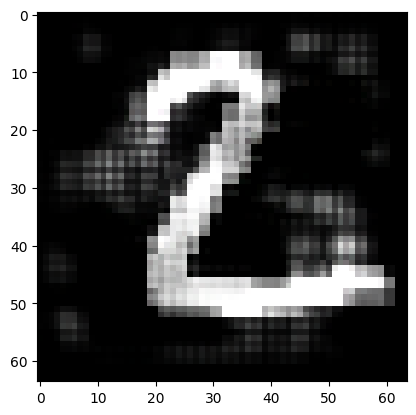

In [35]:
plt.imshow(adv_image, cmap='gray')

In [36]:
print(reshaped_sample_twos.shape)

(10, 1, 64, 64, 3)


In [37]:
xb = reshaped_sample_twos[0]
xb.shape

(1, 64, 64, 3)

In [39]:
# x_test_adv, perturbation = fgsm(model_mnist, reshaped_sample_twos[0], class_arr[0], 0.025)

In [39]:
# adv_image = np.squeeze(x_test_adv)
# adv_image = np.expand_dims(adv_image, axis=2)
# org_image = np.expand_dims(np.squeeze(xb), axis=2)
# perturbation = np.expand_dims(np.squeeze(perturbation), axis=2)
# org_image.shape
# adv_image.shape
# plt.imshow(adv_image, cmap='gray')

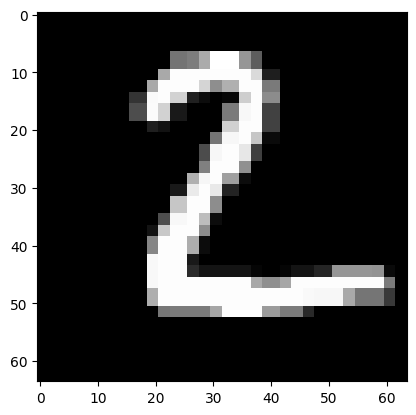

In [40]:
plt.imshow(org_image, cmap='gray')

In [42]:
adv_pred = model_custom.predict(x_test_adv)
org_pred = model_custom.predict(xb)

org_pred = np.argmax(org_pred[1])
adv_pred = np.argmax(adv_pred[1])
print(f"org_pred {org_pred} \t adv_pred {adv_pred}")

NameError: name 'x_test_adv' is not defined

# Batch distance measure

In [43]:
# flatten the image array as a 1D array
org_image_flattened = org_image.flatten()
adv_image_flattened = adv_image.flatten()

distance = np.linalg.norm(org_image_flattened - adv_image_flattened)
distance = round(distance, 2)
print(distance)

6.66


In [29]:
# adv_image = np.squeeze(attack_results[0][0])
# adv_image = np.expand_dims(adv_image, axis=2)
# org_image = np.expand_dims(np.squeeze(reshaped_sample_twos[0]), axis=2)
# perturbation = np.expand_dims(np.squeeze(attack_results[0][1]), axis=2)
# org_image.shape
# adv_image.shape

In [40]:
def batch_distance_measure(adv_img_arr, org_img_arr):
    l2_norm_distance = []
    for adv_img, org_img in zip(adv_img_arr, org_img_arr):
        cur_adv_img = np.array(adv_img[0])
        # print(cur_adv_img.shape)
        # print(org_img.shape)
        adv_img_flattened = cur_adv_img.flatten()
        org_img_flattened = org_image.flatten()
        distance = np.linalg.norm(org_img_flattened - adv_img_flattened)
        distance = format(distance, '.2f')
        l2_norm_distance.append(distance)
    return l2_norm_distance
        

In [41]:
l2_norm_distance = batch_distance_measure(attack_results, reshaped_sample_twos)
print(l2_norm_distance)

['13.88', '43.08', '34.94', '38.41', '37.55', '40.05', '41.55', '47.61', '45.49', '46.97']


In [49]:
l2_norm_distance = batch_distance_measure(attack_results, reshaped_sample_twos)
print(l2_norm_distance) 

['1.57', '42.87', '34.72', '39.21', '37.61', '39.95', '39.88', '43.57', '44.47', '46.94']


# Visualize predictions and images

In [89]:
# fig = plt.figure(figsize=(10, 10))

# rows = 1
# columns = 3

# fig.add_subplot(rows, columns, 1)
# plt.imshow(org_image, cmap='gray')
# plt.axis('off')
# plt.title(f'Original Image \n predictions: {org_pred}')

# fig.add_subplot(rows, columns, 2)
# plt.imshow(perturbation, cmap='gray')
# plt.axis('off')
# plt.title(f'Pertubation\n /Distance: {distance}')

# fig.add_subplot(rows, columns, 3)
# plt.imshow(adv_image, cmap='gray')
# plt.axis('off')
# plt.title(f'Adversarial Image \n Prediction: {adv_pred}')

In [46]:
predi = model_mnist.predict(reshaped_sample_twos[0])
reshaped_sample_twos[0].shape
attack_results[0][0].shape
predioo = model_mnist.predict(attack_results[0][0])
print(np.argmax(predi), np.argmax(predioo))

NameError: name 'model_mnist' is not defined

In [42]:
def batch_visualization(adv_img_pert_arr, org_img_arr, dist_arr, model=None):
    total_plots = len(dist_arr)
    rows = total_plots
    columns = 3
    for idx in range(total_plots):
        fig = plt.figure(figsize=(10, 10))
        org_pred = model.predict(reshaped_sample_twos[0])
        list_org_pred = list(org_pred)
        list_org_pred = list_org_pred[1][0]
        org_pred_cls = np.argmax(org_pred)
        org_conf = round(list_org_pred[org_pred_cls], 1)
        cur_org_img = org_img_arr[idx]
        fig.add_subplot(rows, columns, 1)
        cur_org_img_sq = np.squeeze(cur_org_img)
        plt.imshow(cur_org_img_sq, cmap='hot')
        plt.axis('off')
        plt.title(f'Original Image \n predictions: {org_pred_cls} \n ')

        cur_dist = dist_arr[idx]
        fig.add_subplot(rows, columns, 2)
        cur_pert_img = np.squeeze(perturbation)
        plt.imshow(cur_pert_img, cmap='hot')
        plt.axis('off')
        plt.title(f'Pertubation\n /Distance: {cur_dist}')

        cur_adv_img = adv_img_pert_arr[idx][0]
        adv_pred = model.predict(cur_adv_img)
        adv_pred_cls = np.argmax(adv_pred)
        list_adv_pred = list(adv_pred)
        list_adv_pred = list_adv_pred[1][0]
        adv_conf = format(list_adv_pred[adv_pred_cls], '.1f')
        cur_adv_img_sq = np.squeeze(cur_adv_img)
        fig.add_subplot(rows, columns, 3)
        plt.imshow(cur_adv_img_sq, cmap='hot')
        plt.axis('off')
        plt.title(f'Adversarial Image \n Prediction: {adv_pred_cls} \n Confidence {adv_conf}')
        
    plt.show()

1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


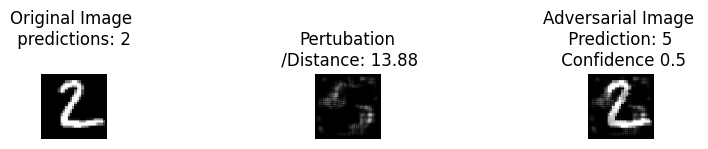

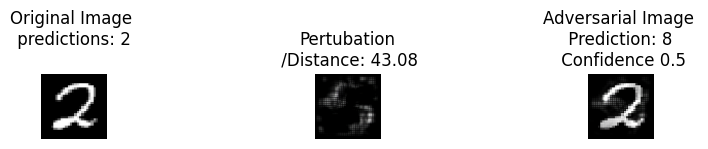

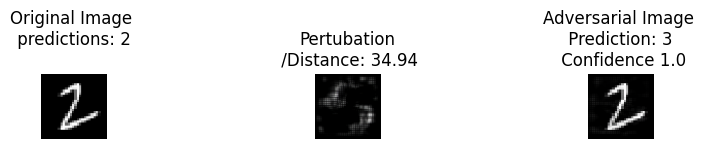

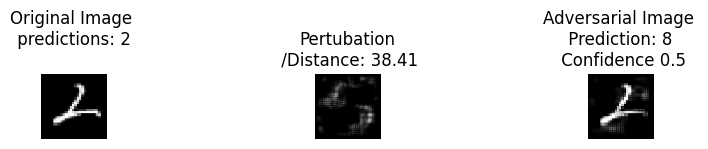

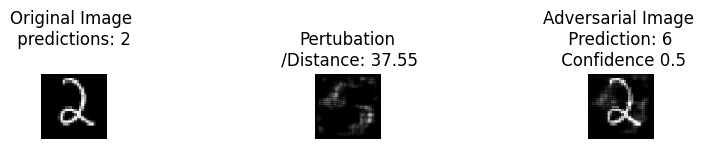

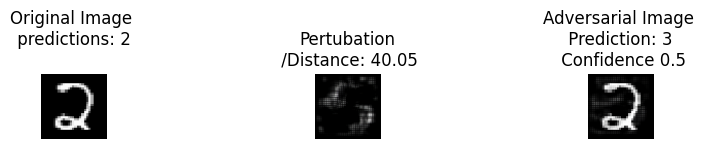

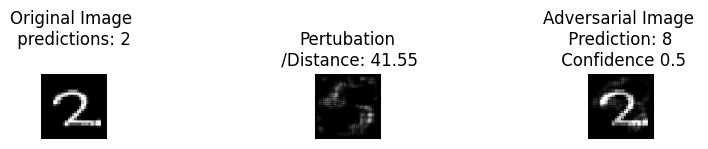

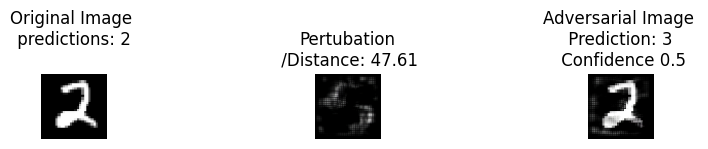

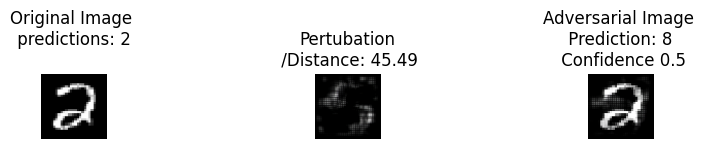

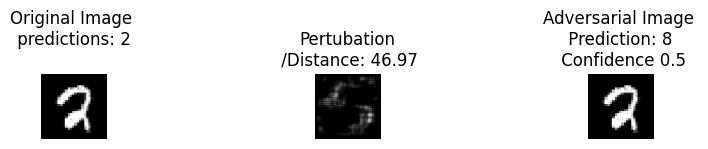

In [44]:
batch_visualization(attack_results, reshaped_sample_twos, l2_norm_distance, model=model_vgg16)

1/1 [==============================] - 0s 89ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


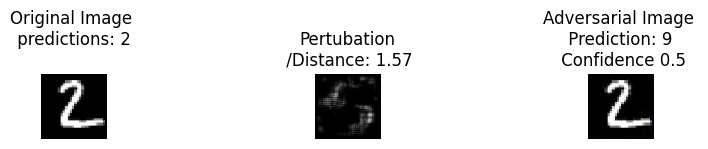

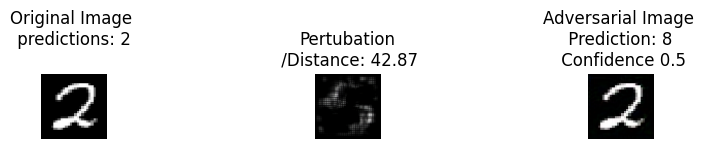

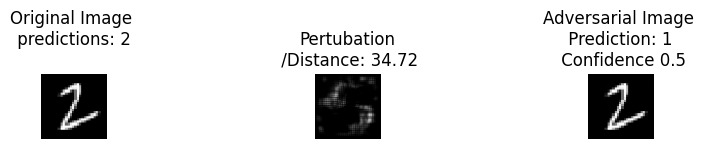

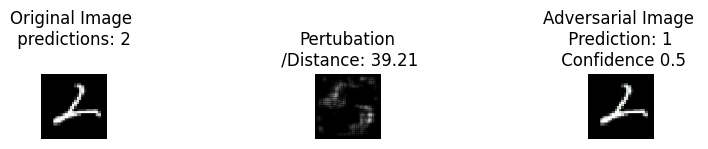

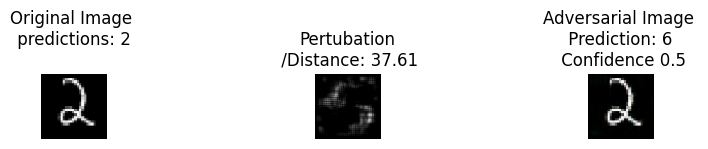

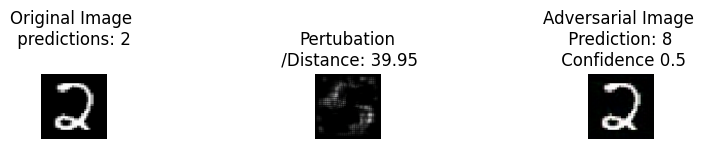

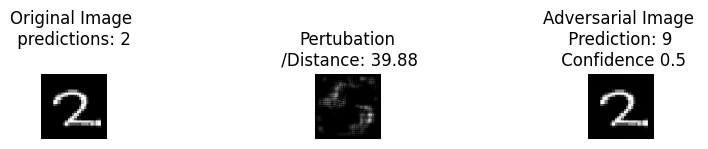

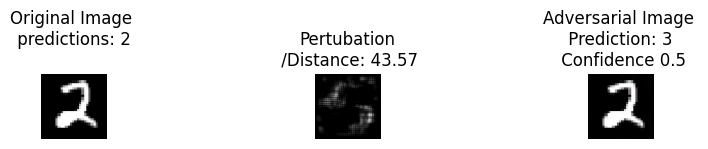

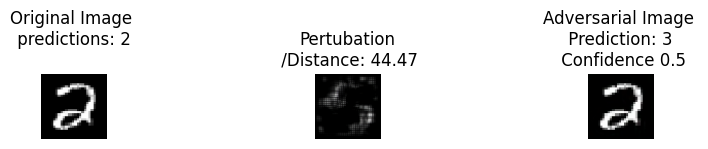

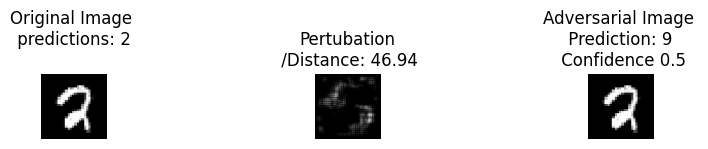

In [50]:
batch_visualization(attack_results, reshaped_sample_twos, l2_norm_distance, model=model_vgg16)

In [ ]:
# use confusion matrix across different classes for each attack